In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import statsmodels.api as sm

from utils import *

Initial notebook for exploring modeling with a reduced dataset. Here are the possible steps.

[X] load in data

[X] run model with only numerical columns that includes standard scalar, train test split

[X] visualize weights

[X] run same model without sdoh columns

[X] do model comparision


Initial numerical columns are as follows:
```
cols_of_interest = [
    "hospital_ownership",
    ?"av_payment_amount_py",
    *"average_hcc_beneficiary_risk_score",
    *"socioeconomic_status_sum",
    *"hh_characteristics_sum",
    *"minority_status_sum",
    *"housing_status_sum",
    "series_themes_sum",
    *"overall_hosp_linear_mean_value",
    *"patient_safety_score",
    "readmission_rate",
    "condition_name",
]
``````

# load in 

In [2]:
DATA_PATH = Path("/Users/jessbreda/Desktop/github/ca-sdoh/data")

cols_of_interest = [
    "hospital_ownership",
    "avg_payment_amount_py",
    "average_hcc_beneficiary_risk_score",
    "socioeconomic_status_sum",
    "hh_characteristics_sum",
    "minority_status_sum",
    "housing_status_sum",
    "series_themes_sum",
    "overall_hosp_linear_mean_value",
    "patient_safety_score",
    "number_of_readmissions",
    "number_of_discharges",
    "condition_name",
]

df = pd.read_csv(
    (DATA_PATH / "obt_slim.csv"),
    usecols=cols_of_interest,
)

# drop nans & rows with -999 (the nan equivalent in the sdoh data)
df.dropna(inplace=True)
df = df[df != -999].dropna()

# remaking readmission rate because it was an int, should be a float w/ decimals
df["readmission_rate"] = (
    df["number_of_readmissions"] / df["number_of_discharges"]
) * 100
df.drop(columns=["number_of_readmissions", "number_of_discharges"], inplace=True)

## Numeric Variables

In [10]:
## Make df with X,y
model_name = "linear_numeric"
# filter df to only numeric columns
numeric_only = df.select_dtypes(include=["float64"])

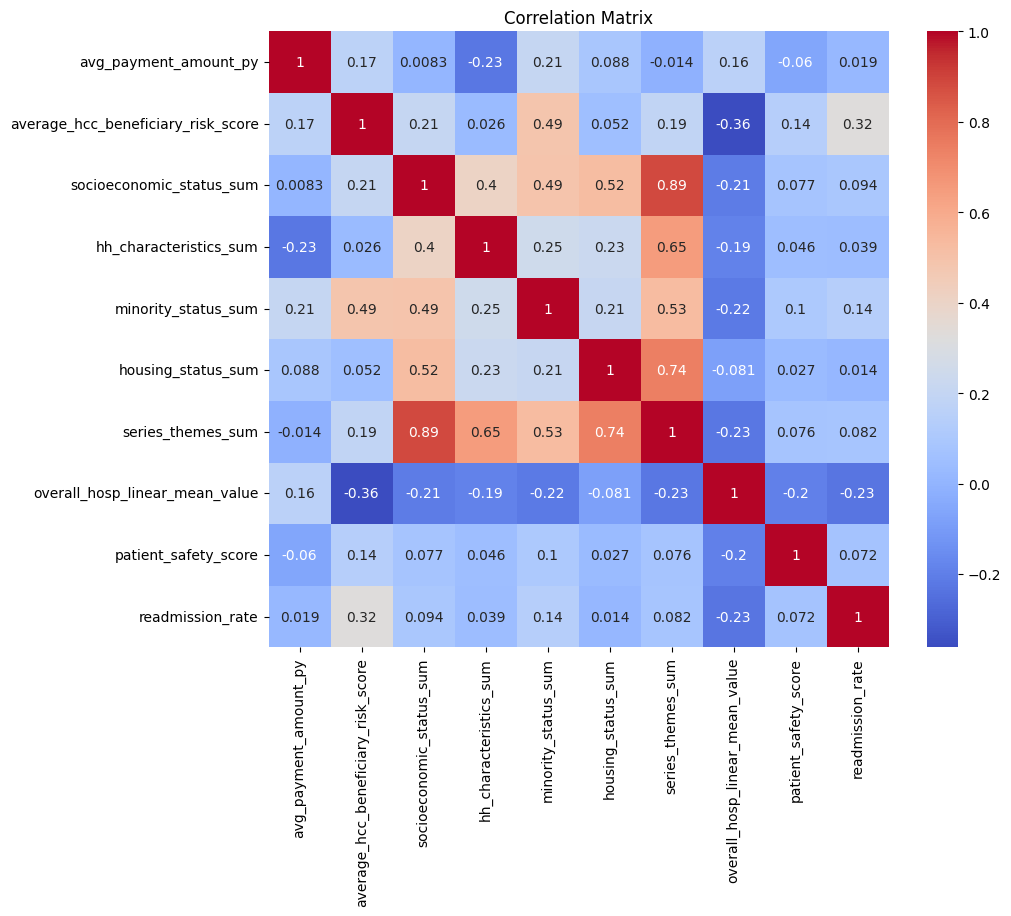

In [11]:
# Assuming your DataFrame is called 'data'
correlation_matrix = numeric_only.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

#### Colinearity 

In [16]:

X = numeric_only.drop(columns=["readmission_rate"])
X = sm.add_constant(X)  # Add a constant column for the intercept

vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [
    np.inf
    if col != "const" and (1 - sm.OLS(X[col], X.drop(columns=col)).fit().rsquared) == 0
    else 1 / (1 - sm.OLS(X[col], X.drop(columns=col)).fit().rsquared)
    for col in X.columns
]

print(vif)

                              Feature          VIF
0                               const  1451.724570
1               avg_payment_amount_py     1.222350
2  average_hcc_beneficiary_risk_score     1.513459
3            socioeconomic_status_sum          inf
4              hh_characteristics_sum          inf
5                 minority_status_sum          inf
6                  housing_status_sum          inf
7                   series_themes_sum          inf
8      overall_hosp_linear_mean_value     1.285343
9                patient_safety_score     1.051389


In [18]:
X = numeric_only.drop(columns=["readmission_rate", "series_themes_sum"])
X = sm.add_constant(X)  # Add a constant column for the intercept

vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [
    np.inf
    if col != "const" and (1 - sm.OLS(X[col], X.drop(columns=col)).fit().rsquared) == 0
    else 1 / (1 - sm.OLS(X[col], X.drop(columns=col)).fit().rsquared)
    for col in X.columns
]

vif

,Feature,VIF
0,const,1451.724570
1,avg_payment_amount_py,1.222350
2,average_hcc_beneficiary_risk_score,1.513459
3,socioeconomic_status_sum,1.927998
4,hh_characteristics_sum,1.322116
5,minority_status_sum,1.767306
6,housing_status_sum,1.413712
7,overall_hosp_linear_mean_value,1.285343
8,patient_safety_score,1.051389


### Linear Model w/ only numeric variables

In [ ]:

numeric_only.drop(
    columns=["series_themes_sum"], inplace=True
)  # this is a aggregate not a feature


## create design matrix, standardize & train/test split
X = numeric_only.drop("readmission_rate", axis=1)
y = numeric_only["readmission_rate"]

# Standardize and center the features
scaler = StandardScaler()

# Standardize the numerical features
scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(X)

# Create a new DataFrame with the standardized numerical features
X_scaled = pd.DataFrame(numerical_features_scaled, columns=X.columns)

# Create train/test splits
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

## Fit model
# Create a new DataFrame with the standardized numerical features
X_scaled = pd.DataFrame(numerical_features_scaled, columns=X.columns)

# Create train/test splits
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

## Fit model---
# Create an instance of the LinearRegression model & fit to train
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict using the trained model
y_pred = linear_model.predict(X_test)

# Get statistics on the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


f"{model_name} mse: {np.round(mse,3)}, r2: {np.round(r2, 2)}"

summary_table = update_summary(model_name, True, r2, mse, X.columns, summary=None)
summary_table

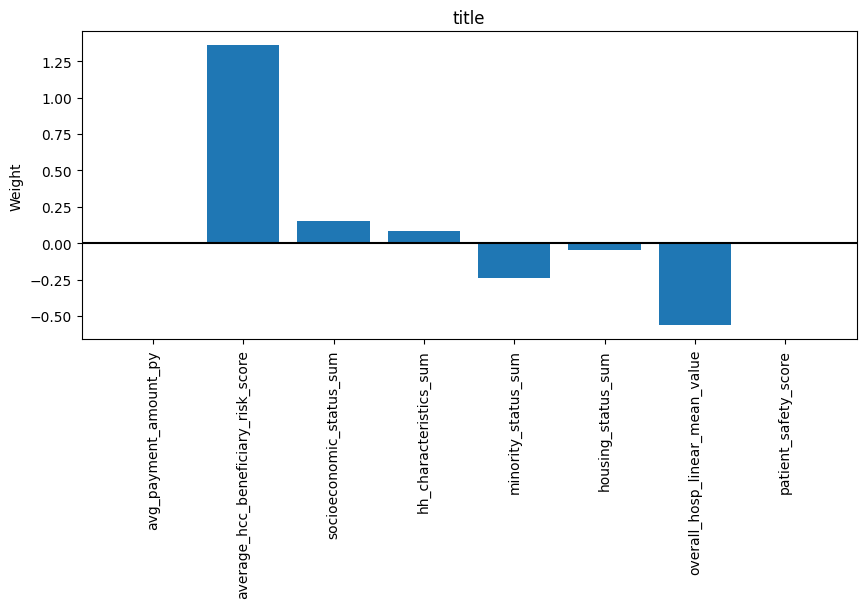

In [4]:
plot_linear_weights(X, linear_model)

### Linear model w/ only numeric & no SDOH vars

In [5]:
## Make df with X,y---
model_name = "numeric_only_no_sdoh"
numeric_only_no_sdoh = numeric_only.filter(regex="^(?!.*sum).*$")

## create design matrix, standardize & train/test split--
X = numeric_only_no_sdoh.drop("readmission_rate", axis=1)
y = numeric_only_no_sdoh["readmission_rate"]

# Standardize and center the features
scaler = StandardScaler()

# Standardize the numerical features
scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(X)

# Create a new DataFrame with the standardized numerical features
X_scaled = pd.DataFrame(numerical_features_scaled, columns=X.columns)

# Create train/test splits
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

## Fit model---
# Create an instance of the LinearRegression model & fit to train
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict using the trained model
y_pred = linear_model.predict(X_test)

# Get statistics on the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

f"{model_name} mse: {np.round(mse,3)}, r2: {np.round(r2, 2)}"

summary_table = update_summary(
    model_name, False, r2, mse, X.columns, summary=summary_table
)
summary_table

,model_name,w_sdoh,r2,mse,feature_names
0,linear_numeric,True,0.081322,17.880747,"avg_payment_amount_py, average_hcc_beneficiary..."
1,numeric_only_no_sdoh,False,0.082968,17.848710,"avg_payment_amount_py, average_hcc_beneficiary..."


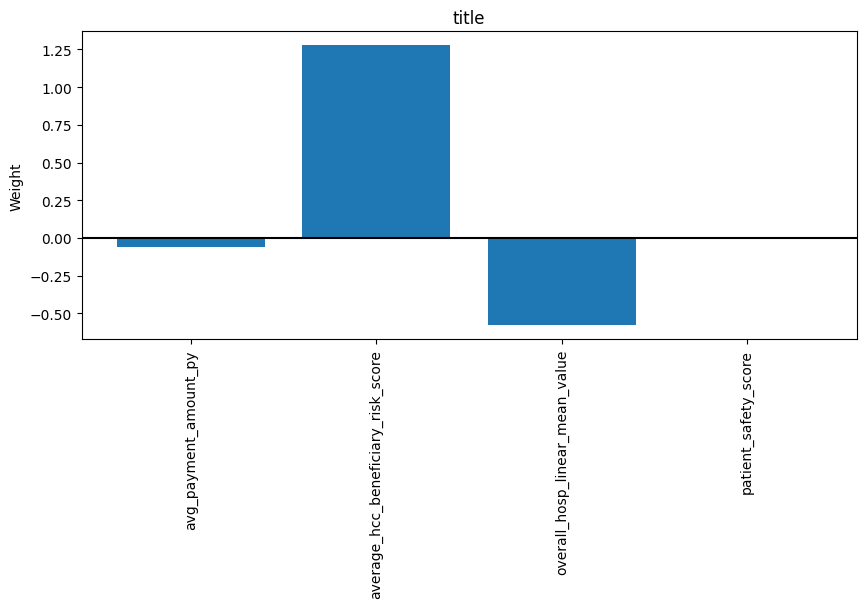

In [7]:
plot_linear_weights(X, linear_model)

### Linear model w/ only numeric + aggregate sdoh

In [8]:
## Make df with X,y
model_name = "linear_numeric_sdoh_agg"
# filter df to only numeric columns
numeric_only = df.select_dtypes(include=["float64"])
numeric_only_sdoh_agg = numeric_only.drop(
    columns=[
        "hh_characteristics_sum",
        "minority_status_sum",
        "socioeconomic_status_sum",
        "housing_status_sum",
    ],
)

## create design matrix, standardize & train/test split--
X = numeric_only_sdoh_agg.drop("readmission_rate", axis=1)
y = numeric_only_sdoh_agg["readmission_rate"]

# Standardize and center the features
scaler = StandardScaler()

# Standardize the numerical features
scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(X)

# Create a new DataFrame with the standardized numerical features
X_scaled = pd.DataFrame(numerical_features_scaled, columns=X.columns)

# Create train/test splits
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

## Fit model---
# Create an instance of the LinearRegression model & fit to train
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict using the trained model
y_pred = linear_model.predict(X_test)

# Get statistics on the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

f"{model_name} mse: {np.round(mse,3)}, r2: {np.round(r2, 2)}"

summary_table = update_summary(
    model_name, True, r2, mse, X.columns, summary=summary_table
)
summary_table

,model_name,w_sdoh,r2,mse,feature_names
0,linear_numeric,True,0.081322,17.880747,"avg_payment_amount_py, average_hcc_beneficiary..."
1,numeric_only_no_sdoh,False,0.082968,17.848710,"avg_payment_amount_py, average_hcc_beneficiary..."
2,linear_numeric_sdoh_agg,True,0.081943,17.868660,"avg_payment_amount_py, average_hcc_beneficiary..."


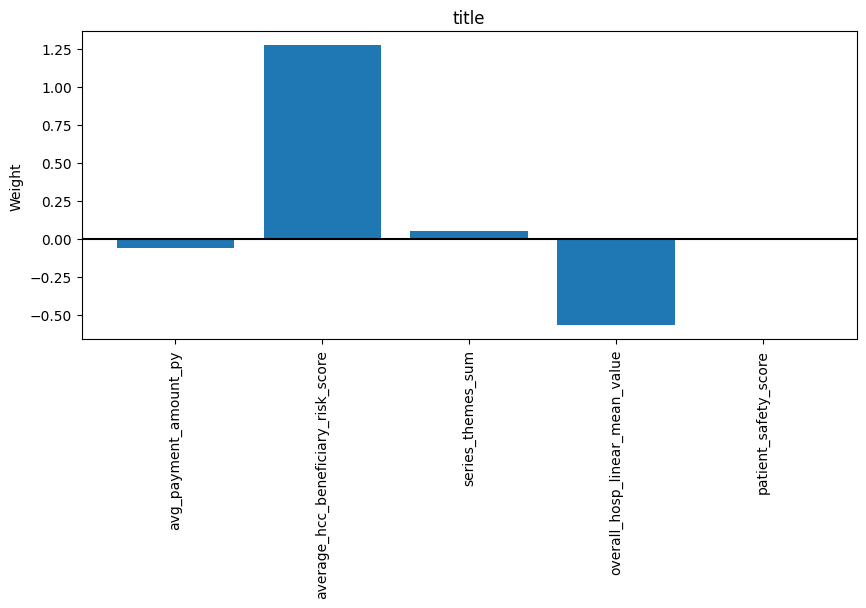

In [9]:
plot_linear_weights(X, linear_model)

### Numeric only conclusion

Based on the fits above, we aren't able to predict readmission rates very well and removing the sdoh variable(s) doesn't affect things. Moreover, although the minority status variable does seem to have a larger weight- when the aggregate sdoh metric is used in place of the subs, the model performance does not change. Lets see if we can get any improvement using categorical vars.

### Numeric + Categorical

[ ] add in single categorical column
    [ ] one hot/dummy encoding
    [ ] drop main
    [ ] concat
    [ ] fit / assess

[ ] add in remaining categorical columns

[ ] fit/assess

[ ] do model comparison w/ w/o SDOH

--- BREAK ---

[ ] reassess -> more vars? more eda? make a function? etc